## Mumbai House Price Prediction using Linear Regression

In [23]:
# import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim

In [24]:
# obtain the raw csv 
data = "../assets/data/mumbai_house_prices.csv"
house_price = pd.read_csv(data)

In [25]:
# printing the info for dataset
print(house_price.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76038 entries, 0 to 76037
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   bhk         76038 non-null  int64  
 1   type        76038 non-null  object 
 2   locality    76038 non-null  object 
 3   area        76038 non-null  int64  
 4   price       76038 non-null  float64
 5   price_unit  76038 non-null  object 
 6   region      76038 non-null  object 
 7   status      76038 non-null  object 
 8   age         76038 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 5.2+ MB
None


In [26]:
house_price.head()

,bhk,type,locality,area,price,price_unit,region,status,age
0,3,Apartment,Lak And Hanware The Residency Tower,685,2.50,Cr,Andheri West,Ready to move,New
1,2,Apartment,Radheya Sai Enclave Building No 2,640,52.51,L,Naigaon East,Under Construction,New
2,2,Apartment,Romell Serene,610,1.73,Cr,Borivali West,Under Construction,New
3,2,Apartment,Soundlines Codename Urban Rainforest,876,59.98,L,Panvel,Under Construction,New
4,2,Apartment,Origin Oriana,659,94.11,L,Mira Road East,Under Construction,New


In [27]:
# create a dictionary to map region to their latitude and longitude
geo = Nominatim(user_agent="Geopy Library", timeout=10)  # Adjust timeout value if error is raised
unique_regions = house_price["region"].unique()
print("Total number of unique values: ", len(unique_regions))
lat_long_dict = {}
unknown_regions = []

for r in unique_regions:
    loc = geo.geocode(r + ", Mumbai")
    if (loc == None):
        unknown_regions.append(r)
        continue
    else:
        latitude = loc.latitude
        longitude = loc.longitude
        lat_long_dict[r] = [latitude, longitude]

print("Geopy could not find the following regions: ", unknown_regions, len(unknown_regions))

# This cell might take about 2 minutes to execute as it is geocoding each region

Total number of unique values:  228
Geopy could not find the following regions:  ['Mira Road East', 'Badlapur East', 'Badlapur West', 'Ambernath West', 'Ulhasnagar', 'Kewale', 'Nala Sopara', 'Karanjade', 'Neral', 'Karjat', 'Dronagiri', 'Navade', 'Owale', 'Ville Parle East', 'Vangani', 'Bhayandar East', 'Ambernath East', 'Nilje Gaon', 'Titwala', 'Koper Khairane', 'Napeansea Road', 'Koproli', 'Anjurdive', 'Taloje', 'Vasai West', 'Vasai east', 'Nalasopara East', 'Saphale', 'Kasheli', 'Panch Pakhdi', 'Hiranandani Estates', 'Vichumbe', 'Sector 17 Ulwe', 'Sector 23 Ulwe', 'Sector 20 Kamothe', 'Sector 30 Kharghar', 'Virar East', 'Sector 8 New panvel', 'Bhayandar West', 'Sector 20 Ulwe', 'Virar West', 'Palava', 'Greater Khanda', 'Sector-35D Kharghar', 'Umroli', 'Sector-9 Ulwe', 'Sector-3 Ulwe', 'kasaradavali thane west', 'Sector 19 Kharghar', 'Kalher', 'Sector 21 Kharghar', 'Usarghar Gaon', 'Patlipada', 'Vevoor', 'Sector 7 Kharghar', 'Badlapur', 'Khanda Colony', 'Gauripada', 'Warai', 'Khatiwal

In [28]:
# we remove all rows which contain unidentified regions and for all rows with identified regions, we add their latitiude and longitude to the data set.
del_idx = []
for i in range(len(house_price)):
    region = house_price.loc[i, "region"]
    if region in unknown_regions:
        del_idx.append(i)
    else:
        lat_long = lat_long_dict[region]
        house_price.at[i, "latitude"] = lat_long[0] 
        house_price.at[i, "longitude"] = lat_long[1]


In [29]:
house_price.drop(del_idx, inplace=True)
house_price = house_price.reset_index(drop=True)

In [30]:
house_price.head()

,bhk,type,locality,area,price,price_unit,region,status,age,latitude,longitude
0,3,Apartment,Lak And Hanware The Residency Tower,685,2.50,Cr,Andheri West,Ready to move,New,19.117249,72.833968
1,2,Apartment,Radheya Sai Enclave Building No 2,640,52.51,L,Naigaon East,Under Construction,New,19.013755,72.846294
2,2,Apartment,Romell Serene,610,1.73,Cr,Borivali West,Under Construction,New,19.229456,72.847990
3,2,Apartment,Soundlines Codename Urban Rainforest,876,59.98,L,Panvel,Under Construction,New,18.990978,73.065553
4,2,Apartment,Bhoomi Simana Wing A Phase 1,826,3.30,Cr,Parel,Under Construction,New,19.009482,72.837661


In [31]:
house_price.shape

(61217, 11)

In [32]:
# remove columns locality and region since they do not hold with the idea of linear regression
house_price.drop(['locality', 'region'], axis=1, inplace=True)

In [33]:
# print all unique values of categorical columns
print(house_price.type.unique())
print(house_price.age.unique())
print(house_price.status.unique())

['Apartment' 'Villa' 'Independent House' 'Studio Apartment' 'Penthouse']
['New' 'Resale' 'Unknown']
['Ready to move' 'Under Construction']


In [34]:
# dealing with categorical data
house_price["type"].replace({"Studio Apartment":0, "Apartment":0.2, "Independent House":0.4, "Villa": 0.6, "Penthouse": 1}, inplace=True)
house_price["age"].replace({"New":0, "Resale":1, "Unknown": 0.5}, inplace=True)
house_price["status"].replace({"Ready to move":0, "Under Construction":1}, inplace=True)

In [35]:
# calculating price in Crores for each using price and price_unit
for i in range(len(house_price)):  
    price_unit = house_price.loc[i, "price_unit"]

    if price_unit == "L":
        house_price.at[i, "price"] = (house_price.at[i, "price"] / 100)
  
house_price.drop(["price_unit"], axis=1, inplace=True)

In [36]:
house_price.head()

,bhk,type,area,price,status,age,latitude,longitude
0,3,0.2,685,2.5000,0,0.0,19.117249,72.833968
1,2,0.2,640,0.5251,1,0.0,19.013755,72.846294
2,2,0.2,610,1.7300,1,0.0,19.229456,72.847990
3,2,0.2,876,0.5998,1,0.0,18.990978,73.065553
4,2,0.2,826,3.3000,1,0.0,19.009482,72.837661


In [72]:
# Define the ratios for train, test, and validation sets
test_ratio = 0.2
val_ratio = 0.1

indices = list(house_price.index)

# Calculate the number of samples for the testing and validation sets
test_size = int(test_ratio * len(house_price))
val_size = int(val_ratio * len(house_price))

# Split the indices into training, testing, and validation sets
test_indices = indices[:test_size]
val_indices = indices[test_size:test_size+val_size]
train_indices = indices[test_size+val_size:]

# Create training, validation, and testing sets
X_train = house_price.loc[train_indices]
X_val = house_price.loc[val_indices]
X_test = house_price.loc[test_indices]

# Extract target variable
y_train = X_train.pop("price").tolist()
y_val = X_val.pop("price").tolist()
y_test = X_test.pop("price").tolist()

print("The size of X_train is: ", X_train.shape)
print("The size of X_val is: ", X_val.shape)
print("The size of X_test is: ", X_test.shape)
print("The size of y_train is: ", len(y_train))
print("The size of y_val is: ", len(y_val))
print("The size of y_test is: ", len(y_test))

The size of X_train is:  (42853, 7)
The size of X_val is:  (6121, 7)
The size of X_test is:  (12243, 7)
The size of y_train is:  42853
The size of y_val is:  6121
The size of y_test is:  12243


In [73]:
X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)

# Normalizing the data
X_train = (X_train - X_mean)/X_std
X_val = (X_val - X_mean)/X_std
X_test = (X_test - X_mean)/X_std

print(X_train.head())

            bhk      type      area    status       age  latitude  longitude
18364 -0.186069  0.015261 -0.220277 -0.857327  1.461599 -0.855333   0.629832
18365 -1.214391  0.015261 -0.640261 -0.857327  1.461599 -0.855333   0.629832
18366 -0.186069  0.015261 -0.277845 -0.857327  1.461599 -0.855333   0.629832
18367 -0.186069  0.015261 -0.277845 -0.857327  1.461599 -0.855333   0.629832
18368 -0.186069  0.015261 -0.199343 -0.857327  1.461599 -0.855333   0.629832


In [74]:
W = np.zeros((X_train.shape[1], 1))
b = 0
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = np.array(y_test)
y_test = y_test.reshape(y_test.shape[0], 1)
y_val = np.array(y_val)
y_val = y_val.reshape(y_val.shape[0], 1)

In [75]:
def fit(X, y, W, b, learning_rate=0.1, num_iterations=500, l2_lambda=0.01):
    m = X.shape[0]
    total_losses = []

    for i in range(num_iterations):
        Z = np.dot(X, W) + b
        diff = Z - y
        dw = (1/m) * np.dot(X.T, diff) + (l2_lambda / m) * W  # L2 regularization
        db = (1/m) * np.sum(diff)

        W = W - learning_rate * dw
        b = b - learning_rate * db

        loss = (1/m) * np.sum(np.abs(diff))
        regularization_loss = (l2_lambda / (2 * m)) * np.sum(np.square(W))
        total_loss = loss + regularization_loss

        total_losses.append(total_loss)
        
        if i % 100 == 0:
            print("Loss after iteration %i: %f" % (i, total_loss))
        
    return W, b, total_losses

In [76]:
def predict(X, W, b):
    z = np.dot(X, W) + b
    # For all negative values, replace them with 0
    z[z < 0] = 0
    return z

In [77]:
# Tuning hyperparameters using validation set
W, b, total_losses = fit(X_train, y_train, W, b, 0.1)

# Calculate the mean absolute error on validation data in Cr
z = predict(X_train, W, b)
mae = np.sum(np.abs(z - y_train)) / len(y_train)
print(mae)

# Reset parameters
W = np.zeros((X_train.shape[1], 1))
b = 0

Loss after iteration 0: 2.023829
Loss after iteration 100: 0.707657
Loss after iteration 200: 0.710135
Loss after iteration 300: 0.710935
Loss after iteration 400: 0.711078
0.6819135792348553


In [78]:
# Train on both training and validation data
W, b, total_losses = fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), W, b, 0.1)

Loss after iteration 0: 1.980784
Loss after iteration 100: 0.699005
Loss after iteration 200: 0.700996
Loss after iteration 300: 0.701796
Loss after iteration 400: 0.701951


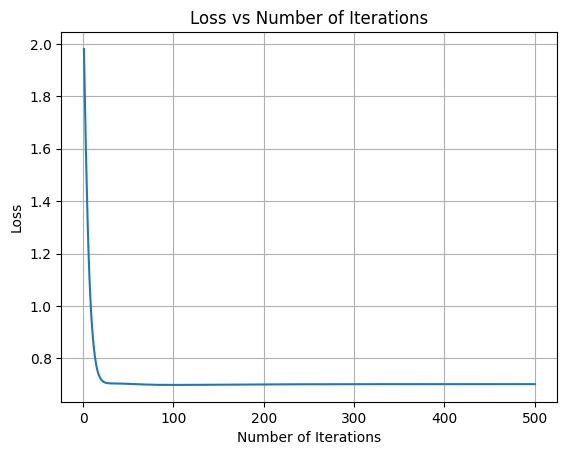

In [79]:
# Plotting missclassifications against the number of iterations
plt.plot(range(1, len(total_losses) + 1), total_losses)
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Number of Iterations')
plt.grid(True)
plt.show()

In [80]:
# Calculate the mean absolute error on test data in Cr
z = predict(X_test, W, b)
mae = np.sum(np.abs(z - y_test)) / len(y_test)
print(mae)

0.6345467583586093


In [81]:
print(W)
print(b)

[[ 0.1547163 ]
 [-0.04002516]
 [ 1.66889565]
 [ 0.17196924]
 [-0.05643254]
 [-0.19802677]
 [-0.67265214]]
2.0332545211306745


In [82]:
# Testing with our own data
X_test.loc[0, "bhk"] = 2
X_test.loc[0, "type"] = 0.2
X_test.loc[0, "area"] = 594
X_test.loc[0, "status"] = 0
X_test.loc[0, "age"] = 1
X_test.loc[0, "latitude"] = 19.432762
X_test.loc[0, "longitude"] = 72.84564

# Normalizing the sample
X_test.loc[0] = (X_test.loc[0] - X_mean) / X_std

z = predict(X_test.loc[0], W, b)
print("The price of house in Cr: ", z)

The price of house in Cr:  [0.67643085]
